# (시도) Node Classification with Graph Neural Networks
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [GNN]

### Import

In [49]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 데이터 구성

---

```python
p = 0.3
papers = pd.concat([pd.DataFrame(np.array([[p]*1500,[1-p]*1500]).reshape(1000,3),columns=['X1','X2','X3']),
           pd.DataFrame(np.array([[1-p]*1500,[p]*1500]).reshape(1000,3),columns=['X4','X5','X6']),
          pd.DataFrame(np.array([['Deep learning']*500,['Reinforcement learning']*500]).reshape(1000,1))],axis=1).reset_index().rename(columns={'index':'paper_id',0:'subject'})
papers['paper_id'] = papers['paper_id']+1
#시도1: 2500 행 모두 target/source 상관없이 1~1000 임의 부여
citations = pd.DataFrame(np.array([[np.random.choice(range(1,1001),size=(2500,1))],
                                   [np.random.choice(range(1,1001),size=(2500,1))]]).reshape(2500,2)).rename(columns = {0:'target',1:'source'})
#시도2: 나머지 1250 행 reinforcement learning 행 500~1000를 target, source에 임의 부여
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1250,1)),np.random.choice(range(1,501),size=(1250,1))]).reshape(1250,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1250,1)),np.random.choice(range(501,1001),size=(1250,1))]).reshape(1250,2))],ignore_index=True).rename(columns={0:'target',1:'source'})
```

---

In [50]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [51]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

def filter_36(x, y):
    keep = (y == 3) | (y == 7)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [ ]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [ ]:
X= x_train.reshape(-1,784)/255
y = list(map(lambda x: 0 if x == True else 1,y_train))
XX = x_test.reshape(-1,784)/255
yy = list(map(lambda x: 0 if x == True else 1,y_test))

In [52]:
X = x_test.reshape(-1,784)/255
y = y_test

y가 3이면 0

y가 7이면 1로

In [53]:
add_list = []

In [54]:
add_list.append(X)

In [60]:
papers = pd.concat([pd.DataFrame(np.array(add_list).reshape(-1,784)),pd.DataFrame(np.array(y).reshape(-1,1))],axis=1).reset_index()

In [61]:
column_names = ["paper_id"] + [f"X_{idx}" for idx in range(1,785)] + ["subject"]
papers.columns = column_names
papers['paper_id'] = papers['paper_id'] + 1

In [62]:
papers

,paper_id,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_776,X_777,X_778,X_779,X_780,X_781,X_782,X_783,X_784,subject
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
9996,9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
9997,9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
9998,9999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [63]:
_a = []

In [64]:
for i in range(1,len(papers)+1):
    for j in range(1,len(papers)+1):
        _a.append([i])
        _a.append([j])

In [65]:
citations = pd.DataFrame(np.array(_a).reshape(-1,2)).rename(columns = {0:'target',1:'source'})

In [66]:
citations

,target,source
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
99999995,10000,9996
99999996,10000,9997
99999997,10000,9998
99999998,10000,9999


### 그래프 표현

In [67]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

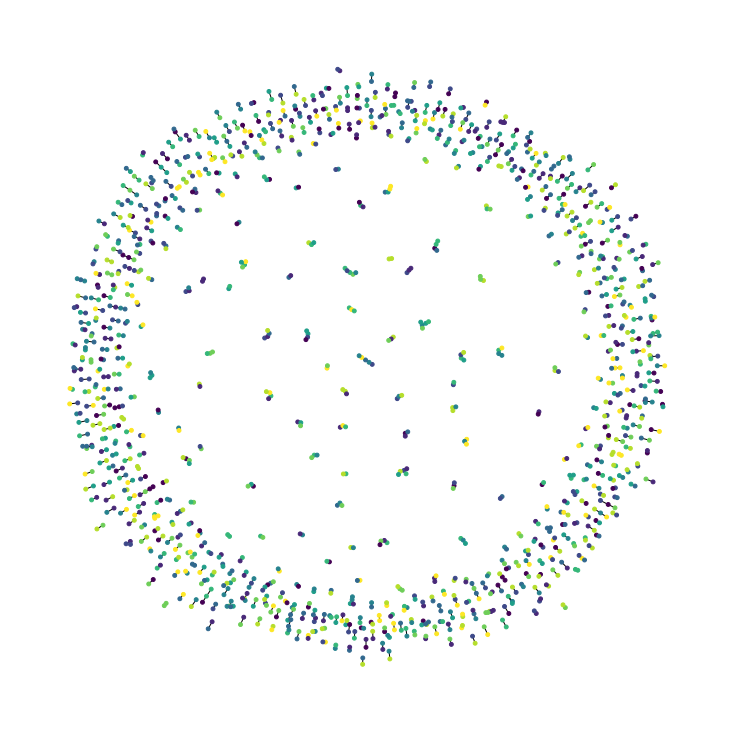

In [68]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=800))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### Test vs Train

In [69]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (4978, 786)
Test data shape: (5022, 786)


In [70]:
hidden_units = [32,32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [71]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [72]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [73]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [74]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [75]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 784)]        0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           29440       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [76]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
17/17 [==============================] - 2s 30ms/step - loss: 2.7695 - acc: 0.2543 - val_loss: 1.3596 - val_acc: 0.6319
Epoch 2/300
17/17 [==============================] - 0s 17ms/step - loss: 1.4299 - acc: 0.5290 - val_loss: 0.9997 - val_acc: 0.6613
Epoch 3/300
17/17 [==============================] - 0s 19ms/step - loss: 1.0315 - acc: 0.6530 - val_loss: 1.1050 - val_acc: 0.6171
Epoch 4/300
17/17 [==============================] - 0s 19ms/step - loss: 0.8621 - acc: 0.7135 - val_loss: 0.8112 - val_acc: 0.7323
Epoch 5/300
17/17 [==============================] - 0s 19ms/step - loss: 0.7562 - acc: 0.7561 - val_loss: 0.6325 - val_acc: 0.8193
Epoch 6/300
17/17 [==============================] - 0s 19ms/step - loss: 0.6822 - acc: 0.7778 - val_loss: 0.5994 - val_acc: 0.8286
Epoch 7/300
17/17 [==============================] - 0s 19ms/step - loss: 0.6461 - acc: 0.7925 - val_loss: 0.4609 - val_acc: 0.8862
Epoch 8/300
17/17 [==============================] - 0s 19ms/step - loss: 0.

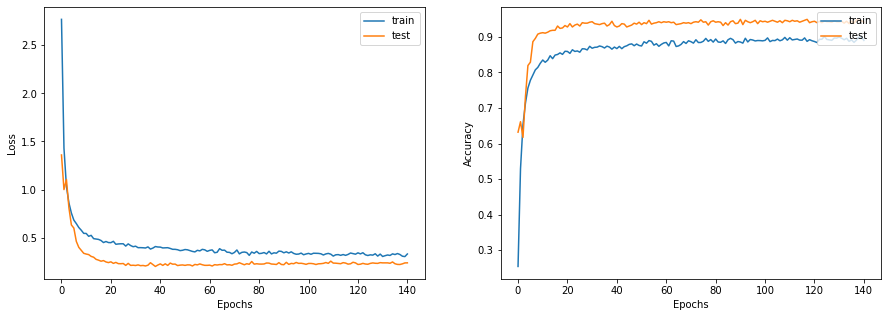

In [77]:
display_learning_curves(history)

In [78]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 93.53%


### baseline 모델 예측

In [79]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [80]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- 0: 1.66%
- 1: 4.96%
- 2: 4.06%
- 3: 18.42%
- 4: 0.11%
- 5: 5.35%
- 6: 0.61%
- 7: 1.47%
- 8: 61.11%
- 9: 2.24%
Instance 2:
- 0: 2.74%
- 1: 0.35%
- 2: 4.05%
- 3: 2.95%
- 4: 3.79%
- 5: 1.18%
- 6: 1.71%
- 7: 1.29%
- 8: 46.99%
- 9: 34.95%
Instance 3:
- 0: 0.95%
- 1: 0.66%
- 2: 1.5%
- 3: 0.59%
- 4: 0.87%
- 5: 16.32%
- 6: 46.97%
- 7: 0.04%
- 8: 31.38%
- 9: 0.71%
Instance 4:
- 0: 7.72%
- 1: 0.42%
- 2: 1.87%
- 3: 2.67%
- 4: 0.2%
- 5: 7.39%
- 6: 0.35%
- 7: 0.54%
- 8: 76.72%
- 9: 2.12%
Instance 5:
- 0: 0.09%
- 1: 0.1%
- 2: 91.0%
- 3: 0.39%
- 4: 0.0%
- 5: 0.2%
- 6: 0.01%
- 7: 0.1%
- 8: 8.09%
- 9: 0.01%
Instance 6:
- 0: 15.21%
- 1: 4.59%
- 2: 9.47%
- 3: 6.11%
- 4: 0.86%
- 5: 12.2%
- 6: 8.82%
- 7: 1.0%
- 8: 38.83%
- 9: 2.92%
Instance 7:
- 0: 0.47%
- 1: 0.3%
- 2: 0.61%
- 3: 0.32%
- 4: 0.01%
- 5: 3.14%
- 6: 0.14%
- 7: 0.0%
- 8: 94.96%
- 9: 0.05%
Instance 8:
- 0: 1.97%
- 1: 13.92%
- 2: 55.41%
- 3: 1.5%
- 4: 3.07%
- 5: 1.17%
- 6: 3.0%
- 7: 1.1%
- 8: 17.36%
- 9: 1.51%
Instance 9:
- 0: 2.59%

In [81]:
theta = 5000

In [82]:
edge_weights = []

In [ ]:
for i in range(len(citations)):
    edge_weights.append(np.exp(-((citations.target[i] - citations.source[i])**2/theta).sum()))

In [ ]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
#edge_weights = tf.ones(shape=edges.shape[1])
edge_weights = tf.constant(edge_weights,shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Edge weight shape:", edge_weights.shape)
print("Nodes shape:", node_features.shape)

In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

In [ ]:
display_learning_curves(history)

In [ ]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

In [ ]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [ ]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)